# Pumping Test Evaluation - Instationary Phase after Theis and Cooper-Jacob with linear and non-linear fitting in Python

*This notebook is based on Christian Hill's blogpost and notebook: https://scipython.com/blog/linear-and-non-linear-fitting-of-the-theis-equation/, modifications by Tanja Liesch*

## The Theis equation
The _drawdown_ or change in hydraulic head, $s$ (a measure of the water pressure above some geodetic datum) a distance $r$ from a well at time $t$ from which water is being pumped at a constant rate, $Q$, can be modelled using the _Theis_ equation,
$$
s(u) = \frac{Q}{4\pi T}W(u), \quad \mathrm{where}\quad u = \frac{r^2S}{4Tt}.
$$
Here $S$ is the aquifer storage coefficient (volume of water released per unit decrease in $H$ per unit area) and $T$ is the transmissivity (a measure of how much water is transported horizontally per unit time). The _Well Function_, $W(u)$ is simply the exponential integral, $E_1(u).$

In practice, it is often more convenient to use an approximation to the exponential integral: $W(u) \approx -\gamma - \ln u$ where $\gamma=0.577215664\cdots$ is the Euler-Mascheroni constant. This results in an expression for $s(u)$ known as the Cooper-Jacob equation:
$$
s(u) = -\frac{Q}{4\pi T}\left(\gamma + \ln u \right).
$$


The following code uses `scipy.special.exp1` to calculate the full Theis equation, returning $s(u)$ for parameters $Q$, $S$ and $T$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import exp1

def calc_u(r, S, T, t):
    """Calculate and return the dimensionless time parameter, u."""

    return r**2 * S / 4 / T / t

In [2]:
def theis_drawdown(t, S, T, Q, r):
    """Calculate and return the drawdown s(u) for parameters S, T.

    This version uses the Theis equation, s(u) = Q * W(u) / (4.pi.T),
    where W(u) is the Well function for u = Sr^2 / (4Tt).
    S is the aquifer storage coefficient,
    T is the transmissivity (m2/s),
    r is the distance from the well (m), and
    Q is the pumping rate (m3/s).

    """

    u = calc_u(r, S, T, t)
    s_theis = Q/4/np.pi/T * exp1(u)
    return s_theis

Let's simulate a curve for $s(t)$ for a fixed distance from the well, $r=10\;\mathrm{m}$, and pumping rate $Q = 0.002\;\mathrm{m^3/s}$ for a well with parameters $S = 0.001$ and $T = 0.001\;\mathrm{m^2/s}$. We'll add a bit of synthetic normally-distributed noise to get some realistic data simulating measurement errors (since the noise is random, slightly different values will be produced each time you run the code).

In [3]:
Q = 0.002       # Pumping rate from well (m3/s)
r = 10          # Distance from well (m)

# Time grid, seconda.
t = np.array([20, 40, 80, 120, 160, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200])

# Use these for a better fit of S with the Cooper-Jacob approximation, see below
#t = np.array([160, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200])


# Calculate some synthetic data to fit.
S, T = 0.001, 0.001
s = theis_drawdown(t, S, T, Q, r)
# Add some noise.
noise_sd = 1.e-2
s += s * noise_sd * np.random.randn(s.shape[0])
print(s)

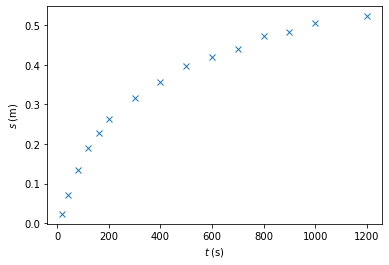

In [4]:
# Plot the data
plt.plot(t, s, 'x')
plt.xlabel(r'$t\;\mathrm{(s)}$')
plt.ylabel(r'$s\;\mathrm{(m)}$')
plt.show()

## Fitting the data

### Linear least squares fit

It is often the case that $s$ can be measured over time at a fixed distance from the well, $r$, for a known pumping rate $Q$, and it is required that the parameters $S$ and $T$ be found. The Theis equation is clearly non-linear in $t$, but the Cooper-Jacob approximation to it can produce a straight-line plot, since:
$$
s(u) = -\frac{Q}{4\pi T}\left[\gamma + \ln\left(\frac{r^2S}{4T}\right)\right] + \frac{Q}{4\pi T}\ln t,
$$
So a plot of $s$ against $\ln t$ is a straight line with intercept and gradient
$$
c = -\frac{Q}{4\pi T}\left[\gamma + \ln\left(\frac{r^2S}{4T}\right)\right]
\quad \mathrm{and}\quad
m = \frac{Q}{4\pi T}
$$
whence,
$$
T = \frac{Q}{4\pi m},
\quad
S = \frac{4T}{r^2}\exp\left[-\left(\frac{c}{m}+\gamma\right)\right]
$$

The most straightforward approach is to use NumPy's [`polyfit`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html) routine to fit a first-order polynomial (i.e. a straight line) through the data points $(s_i, \ln t_i)$:

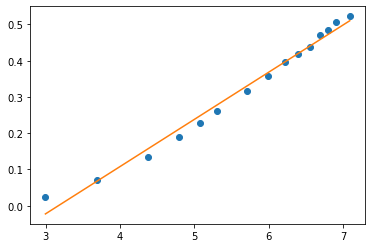

m = 0.13016475639638475, c = -0.41269296927006316
rms residual = 0.06965882008285715


In [5]:
# fit s, ln(t)
lnt = np.log(t)
coeffs = np.polyfit(np.log(t), s, 1)
# plot the data and the fitted straight line
plt.plot(lnt, s, ls='', marker='o')
fit_line = np.poly1d(coeffs)(lnt)
plt.plot(lnt, fit_line)
plt.show()
# Output the fitted coefficients and report the rms residual
print('m = {}, c = {}'.format(*coeffs))
rms_residual = np.sqrt(np.sum((fit_line - s)**2))
print('rms residual =', rms_residual)

The parameters $S$ and $T$ which best fit the data are found to be as follows:

In [6]:
m, c = coeffs
def get_S_and_T(m, c):
    Tfit = Q / 4 / np.pi / m
    Sfit = 4 * Tfit / r**2 * np.exp(-(c/m + np.euler_gamma))
    return Sfit, Tfit

Sfit, Tfit = get_S_and_T(m,c)
print('S = %.3e' %Sfit)
print('T = %.3e m2/s' %Tfit)

S = 6.541e-04
T = 1.223e-03 m2/s


While $T$ seems to fit fairly well to the value we used above, we have a slightly too low value for $S$ (which should be about 0.001). If we look more closely too the line-fit above, we can see that the first values do not fit well. The cause is, that the Cooper-Jacob approximation is only valid for small values of u, i.e. longer times. If we would delete the first four time values we produced above and repeat the line fit, we would see that $S$  fits better (try it!).

The same analysis can be performed using [`numpy.linalg.lstsq`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html) which returns the sum of the square residuals along with other information about the fit:

In [7]:
A = np.vstack((lnt, np.ones_like(t))).T
x, sq_resid, rank, sing_vals = np.linalg.lstsq(A, s, rcond=None)
m, c = x

Sfit, Tfit = get_S_and_T(m,c)

print('S = %.3e' %Sfit)
print('T = %.3e m2/s' %Tfit)
print('rms residual = %.3f' %(np.sqrt(sq_resid[0])))

S = 6.541e-04
T = 1.223e-03 m2/s
rms residual = 0.070


### Nonlinear least squares fit

The full Theis equation can only be fit with a nonlinear routine such as [`scipy.optimize.curve_fit`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.curve_fit.html) or [`scipy.optimize import leastsq`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.leastsq.html). `curve_fit` can fit a function directly; it calls `leastsq` which minimizes the sum of squares of a set of equations: in this context, the residuals between the observed data and modelled $s(t)$.

#### `curve_fit`

`curve_fit` does not need an initial guess for the fit parameters (it sets them equal to 1 if none is provided, which may or may not be appropriate depending on the function). The function to be fit must take the independent variable as its first argument (here, $t$) and the parameters to be fit as the remaining arguments. Since we don't want to fit $Q$ and $r$, we'll define a wrapper function to pick them up in global scope and send them to `theis_drawdown` which requires them.

In [8]:
from scipy.optimize import curve_fit

def theis_func(t, S, T):
    return theis_drawdown(t, S, T, Q, r)

popt, pcov = curve_fit(theis_func, t, s, maxfev=1000)
Sfit, Tfit = popt
print('S = %.3e' %Sfit)
print('T = %.3e m2/s' %Tfit)
theis_fit = theis_drawdown(t, Sfit, Tfit, Q, r)
rms_resid = np.sqrt(np.sum((s - theis_fit)**2))
print('rms residual = %.3f' %(rms_resid))

S = 1.003e-03
T = 9.964e-04 m2/s
rms residual = 0.014


We see that $S$ and $T$ fit well to the values we used above ($S = 0.001$ and $T = 0.001\;\mathrm{m^2/s}$). We can also plot the values along with the fitted Theis-Curve:

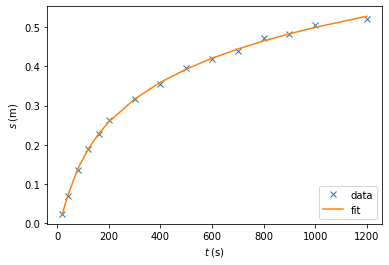

In [9]:
plt.plot(t, s, 'x', label='data')
plt.plot(t, theis_fit, label='fit')
plt.xlabel(r'$t\;\mathrm{(s)}$')
plt.ylabel(r'$s\;\mathrm{(m)}$')
plt.legend(loc=4)
plt.show()

#### Analysing a real world pumping test

If we want to analyse a real world pumping test, we must replace the synthetic data values we created above with the real values, along with the correct pumping rate $Q$ and distance to pumping well $r$. Here is an example (values from excercise a):

In [10]:
Q = 0.006       # Pumping rate from well (m3/s)
r = 40          # Distance from well (m)
t = np.array([10,18,32,57,100,178,316,562,1000,1780,3160,5620,10000])
s = np.array([0.005,0.02,0.05,0.09,0.16,0.23,0.31,0.40,0.49,0.58,0.67,0.75,0.82])



We use the Theis curve fit from above again:

In [11]:
from scipy.optimize import curve_fit

def theis_func(t, S, T):
    return theis_drawdown(t, S, T, Q, r)

popt, pcov = curve_fit(theis_func, t, s, maxfev=1000) 
Sfit, Tfit = popt
print('S = %.3e' %Sfit)
print('T = %.3e m2/s' %Tfit)

theis_fit = theis_drawdown(t, Sfit, Tfit, Q, r)
rms_resid = np.sqrt(np.sum((s - theis_fit)**2))
print('rms residual = %.3f' %(rms_resid))

S = 1.946e-04
T = 3.085e-03 m2/s
rms residual = 0.025


If we want to compute the reverse way (compute drawdown $s$ for a given time $t$, pumping rate $Q$ and given $S$ and $T$), we just do the same as above when we computed the synthetic values, but without the noise. Here is an example using the values from excercise b:

In [12]:
# Given values for Q, r, S and T
Q = 0.0053       # Pumping rate from well (m3/s)
r = 100          # Distance from well (m)
S = 0.0001       # Storage Coefficient
T = 0.001        # Transmissivity (m2/s)

# Time grid, seconds - we can use only one or several values here, example is 1 day in seconds
t = np.array([24*60*60])

s = theis_drawdown(t, S, T, Q, r)

print('s = %.2f m'  % (s))
    

s = 2.22 m
